In [3]:
# Cell 0: Install all required packages (run once)
%pip install --upgrade pip
%pip install pandas dask[complete] folium scikit-learn matplotlib numpy scipy


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 1.9 MB/s eta 0:00:01
   ---------------------- ----------------- 1.0/1.8 MB 2.0 MB/s eta 0:00:01
   ---------------------------- ----------- 1.3/1.8 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached folium-0.19.5-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached bokeh-3.7.2-py3-none-any.whl.metadata (12 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached tblib-3.1.0-py3-none-any.whl.metadata (25 kB)
  Using cached zict-3.0.0-py2.py3-none-any.whl.metadata (899 bytes)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
Using cached folium-0.19.5-py2.py3-none-any.whl (110 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 2.2 MB/s eta 0:00:05
   ---- -

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
# Cell 1a: Using Dask to sample without full load
import dask.dataframe as dd

# Read just the columns we need
ddf = dd.read_parquet(
    "training_set/20230327.parquet",
    columns=["deviceid","date","time","lat","lon"]
)

# Sample ~1% of the data (adjust frac to taste), then compute
df_sample = ddf.sample(frac=0.01, random_state=42).compute()

# Peek
df_sample.head()


,deviceid,date,time,lat,lon
1368041,df12db589862173e7ca46fdce7b5359af498bbcfbc4cf0...,27.03.2023,20:10:26,46.239681,14.36996
2706054,752eca68efa594f54fcae346199a2e7a61f126b0568642...,27.03.2023,18:16:10,46.250309,14.35047
3899890,6b1bf1e16058ac2cfc6e85ee1be54f1f462c891fd1d85b...,27.03.2023,07:04:44,46.053940,14.51331
1385795,76f2d769bf8ddeffa47036fb7dfafd555b647082549e91...,27.03.2023,10:06:20,46.081600,14.45907
2315508,c759cddc8248aae54f88f9e9d1a97bb94154cb4f39ab82...,27.03.2023,20:17:01,46.438549,14.03293


In [6]:
# Cell 2: Basic Dataset Overview
print("Shape:", df_sample.shape)
print("\nData types and non-null counts:")
print(df_sample.info())

print("\nMissing values per column:")
print(df_sample.isna().sum())


Shape: (1334530, 5)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
Index: 1334530 entries, 1368041 to 222112
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   deviceid  1334530 non-null  category
 1   date      1334530 non-null  category
 2   time      1334530 non-null  category
 3   lat       1334530 non-null  float32 
 4   lon       1334530 non-null  float32 
dtypes: category(3), float32(2)
memory usage: 56.3 MB
None

Missing values per column:
deviceid    0
date        0
time        0
lat         0
lon         0
dtype: int64


C:\Users\Ali\AppData\Local\Temp\ipykernel_6260\2899928691.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_sample.resample('H').size().plot(title="Number of Pings per Hour")


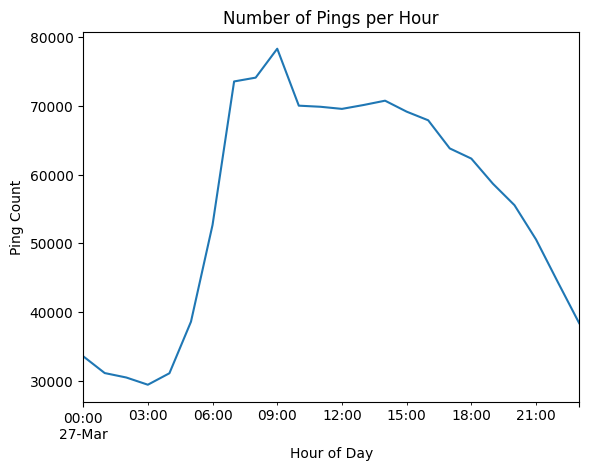

In [8]:
# Cell 3 (fixed): Ping Frequency Over Time
import matplotlib.pyplot as plt

# 1) Convert categorical date/time to plain str before concatenation
datetime_str = df_sample['date'].astype(str) + ' ' + df_sample['time'].astype(str)

# 2) Parse into real datetime
df_sample['datetime'] = pd.to_datetime(
    datetime_str,
    format="%d.%m.%Y %H:%M:%S"
)

# 3) Set as index and plot
df_sample.set_index('datetime', inplace=True)
plt.figure()
df_sample.resample('H').size().plot(title="Number of Pings per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Ping Count")
plt.show()


In [9]:
# Cell 4: Spatial Distribution on Folium Map
import folium

# Center map on median coordinates
center = [df_sample['lat'].median(), df_sample['lon'].median()]
m = folium.Map(location=center, zoom_start=10, control_scale=True, tiles="OpenStreetMap")

# Plot one point every 1000 rows
for idx, row in df_sample.iloc[::1000].iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=2,
        fill=True,
        opacity=0.7
    ).add_to(m)

m.save("spatial_distribution_map.html")
print("Saved spatial map to spatial_distribution_map.html")


Saved spatial map to spatial_distribution_map.html


C:\Users\Ali\AppData\Local\Temp\ipykernel_6260\3623484732.py:19: RuntimeWarning: divide by zero encountered in divide
  speeds = distances / time_deltas
C:\Users\Ali\AppData\Local\Temp\ipykernel_6260\3623484732.py:19: RuntimeWarning: invalid value encountered in divide
  speeds = distances / time_deltas


ValueError: supplied range of [0.0, inf] is not finite

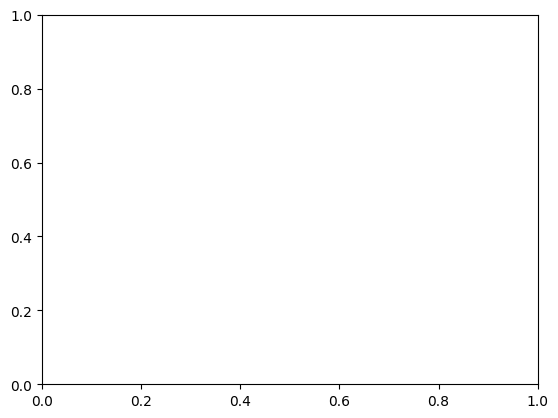

In [ ]:
# Cell 5 (fixed): Speed Distribution Analysis
import numpy as np
import matplotlib.pyplot as plt

# Ensure sorted by datetime index
df_sample.sort_index(inplace=True)

# Compute haversine distances
lats = np.radians(df_sample['lat'].values)
lons = np.radians(df_sample['lon'].values)
dlat = lats[1:] - lats[:-1]
dlon = lons[1:] - lons[:-1]
a = np.sin(dlat/2)**2 + np.cos(lats[:-1]) * np.cos(lats[1:]) * np.sin(dlon/2)**2
distances = 2 * 6371000 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))  # meters

# Compute time deltas (seconds)
time_deltas = df_sample.index.to_series().diff().dt.total_seconds().values[1:]

# **Filter out zero or negative gaps** before computing speeds
valid = time_deltas > 0
distances = distances[valid]
time_deltas = time_deltas[valid]

# Compute speeds (m/s) and drop any infinities/NaNs
speeds = distances / time_deltas
speeds = speeds[np.isfinite(speeds) & (speeds >= 0)]

# Plot histogram
plt.figure()
plt.hist(speeds, bins=50)
plt.title("Histogram of Instantaneous Speeds (m/s)")
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.show()


In [ ]:
# Cell 6: Spatial DBSCAN Clustering & Folium Visualization
from sklearn.cluster import DBSCAN

# Prepare coordinates
coords = df_sample[['lat','lon']].values
coords_rad = np.radians(coords)

# Run DBSCAN (haversine metric)
db = DBSCAN(eps=0.001, min_samples=10, metric='haversine')
labels = db.fit_predict(coords_rad)
df_sample['cluster'] = labels

# Create a colored map of clusters
m2 = folium.Map(location=center, zoom_start=10, control_scale=True, tiles="CartoDB positron")
unique_labels = set(labels)
colors = folium.utilities.color_brewer('Set1')
palette = {lbl: colors[i % len(colors)] for i, lbl in enumerate(unique_labels)}

for idx, row in df_sample.iloc[::1000].iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=3,
        color=palette[row['cluster']],
        fill=True,
        fill_opacity=0.6
    ).add_to(m2)

m2.save("dbscan_clusters_map.html")
print("Saved DBSCAN clusters map to dbscan_clusters_map.html")
